In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.path.abspath('..'), 'src'))

In [2]:
save_folder = r'equilibrium-state-flow-calculations'
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

In [3]:
data_folder = r'data-from-cody'

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd

import FiniteDifference as fd
import LiquidCrystalHelper as lch
import biharm as bh

import time
from importlib import reload

In [5]:
%matplotlib inline
dpi = 700
mpl.rcParams['figure.dpi'] = dpi

In [6]:
l = 10
n = 257

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

dx = x[1] - x[0]

In [7]:
eta_filename = os.path.join(data_folder, "eta_Iso.csv")
eta = np.genfromtxt(eta_filename, delimiter=',')

mu_filename = os.path.join(data_folder, "mu_Iso.csv")
mu = np.genfromtxt(mu_filename, delimiter=',')

nu_filename = os.path.join(data_folder, "nu_Iso.csv")
nu = np.genfromtxt(nu_filename, delimiter=',')

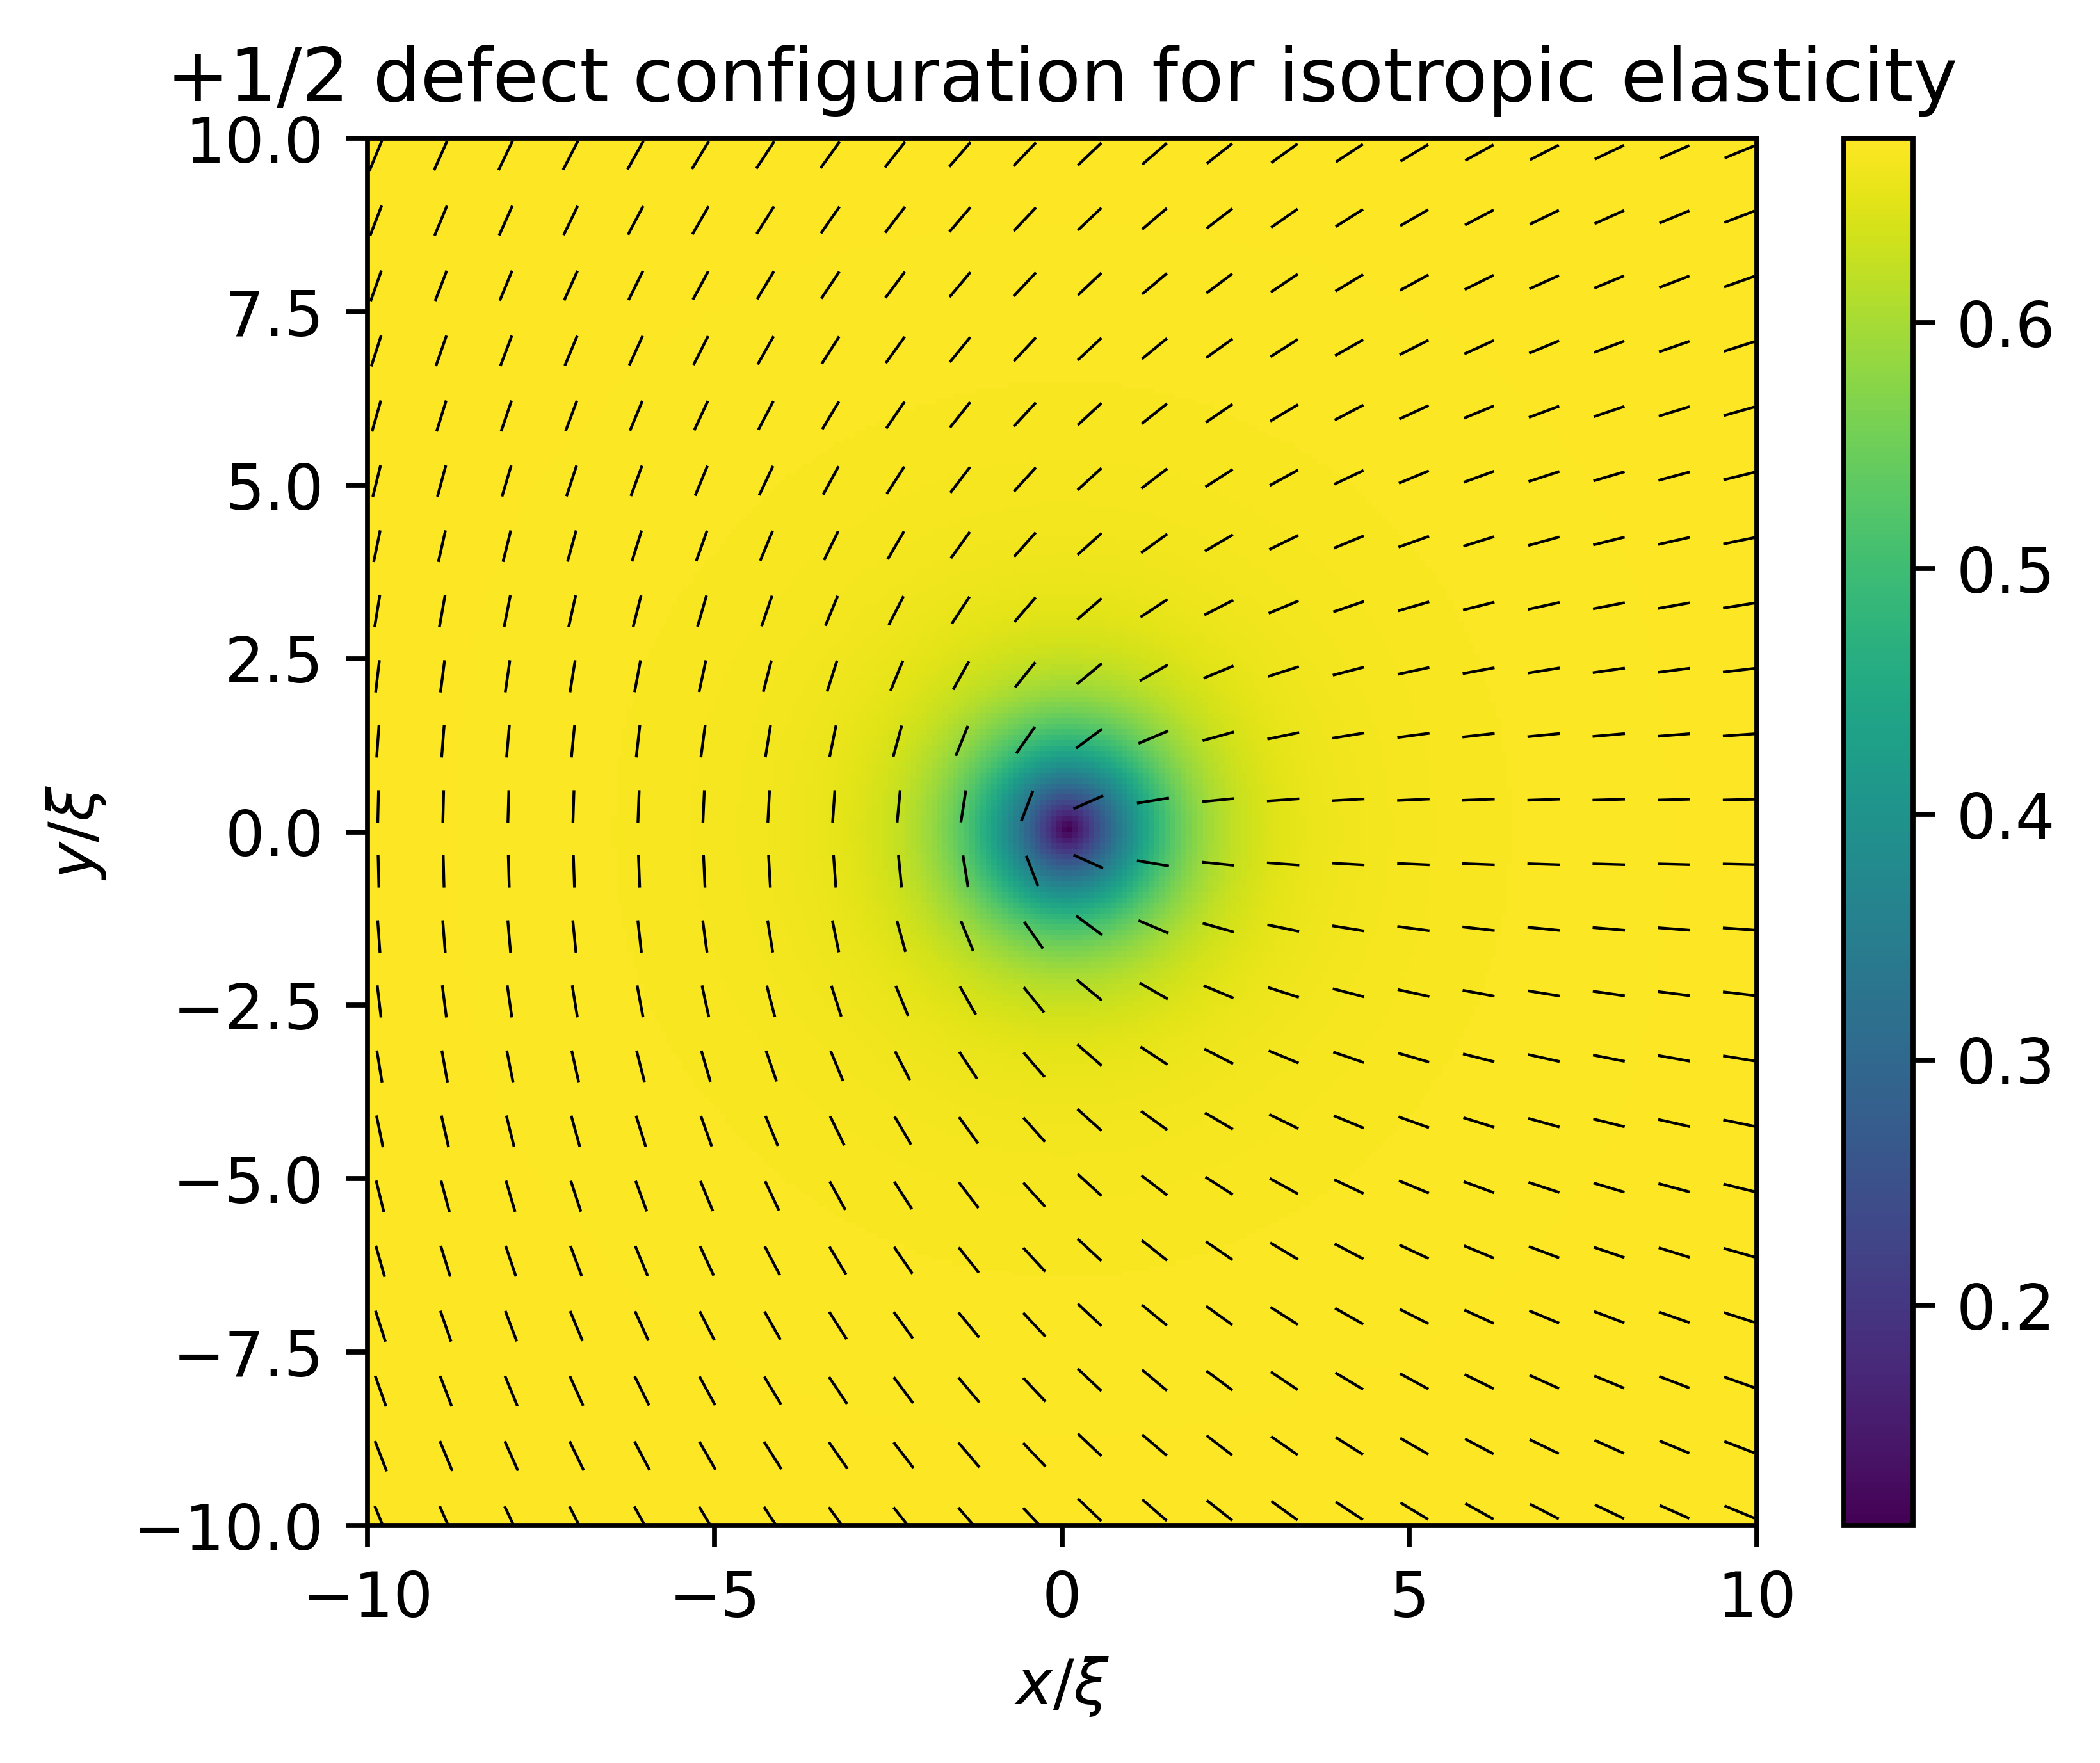

In [8]:
sparse_shape = (20, 20)
S_sparse_shape = (200, 200)
S_cutoff = 0.1

lambda_max = lch.calcQEigenvals(eta, mu, nu)
U, V = lch.calcQEigenvecs(eta, mu, nu, lambda_max, S_cutoff)

sparse_idx = lch.sparseIdx(eta.shape, sparse_shape)
S_sparse_idx = lch.sparseIdx(eta.shape, S_sparse_shape)

fig, ax = plt.subplots(figsize=(5, 4.1))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx], (3/2)*lambda_max[S_sparse_idx])
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)

ax.axis('equal')
fig.colorbar(c, ax=ax)
ax.set_title("+1/2 defect configuration for isotropic elasticity")
ax.set_xlabel(r"$x/\xi$")
ax.set_ylabel(r"$y/\xi$")

config_filename = os.path.join(save_folder, r'iso-configuration.png')
fig.savefig(config_filename)

In [9]:
L = [2*l, 2*l]
shape = [n - 1, n - 1]
alpha = 0
maxiter = 500

bh_solver = bh.Biharm(L, shape, alpha, cg_maxiter=maxiter)

In [10]:
psi = np.zeros(eta.shape)
source_term = (1 / (lch.b - (1/4)*lch.a**2)) * ( 2*lch.f1(eta, mu, nu, dx) + (1/2)*lch.a*lch.f2(eta, mu, nu, dx) )
psi[1:-1, 1:-1], info, calls = bh_solver.solve(source_term[1:-1, 1:-1])

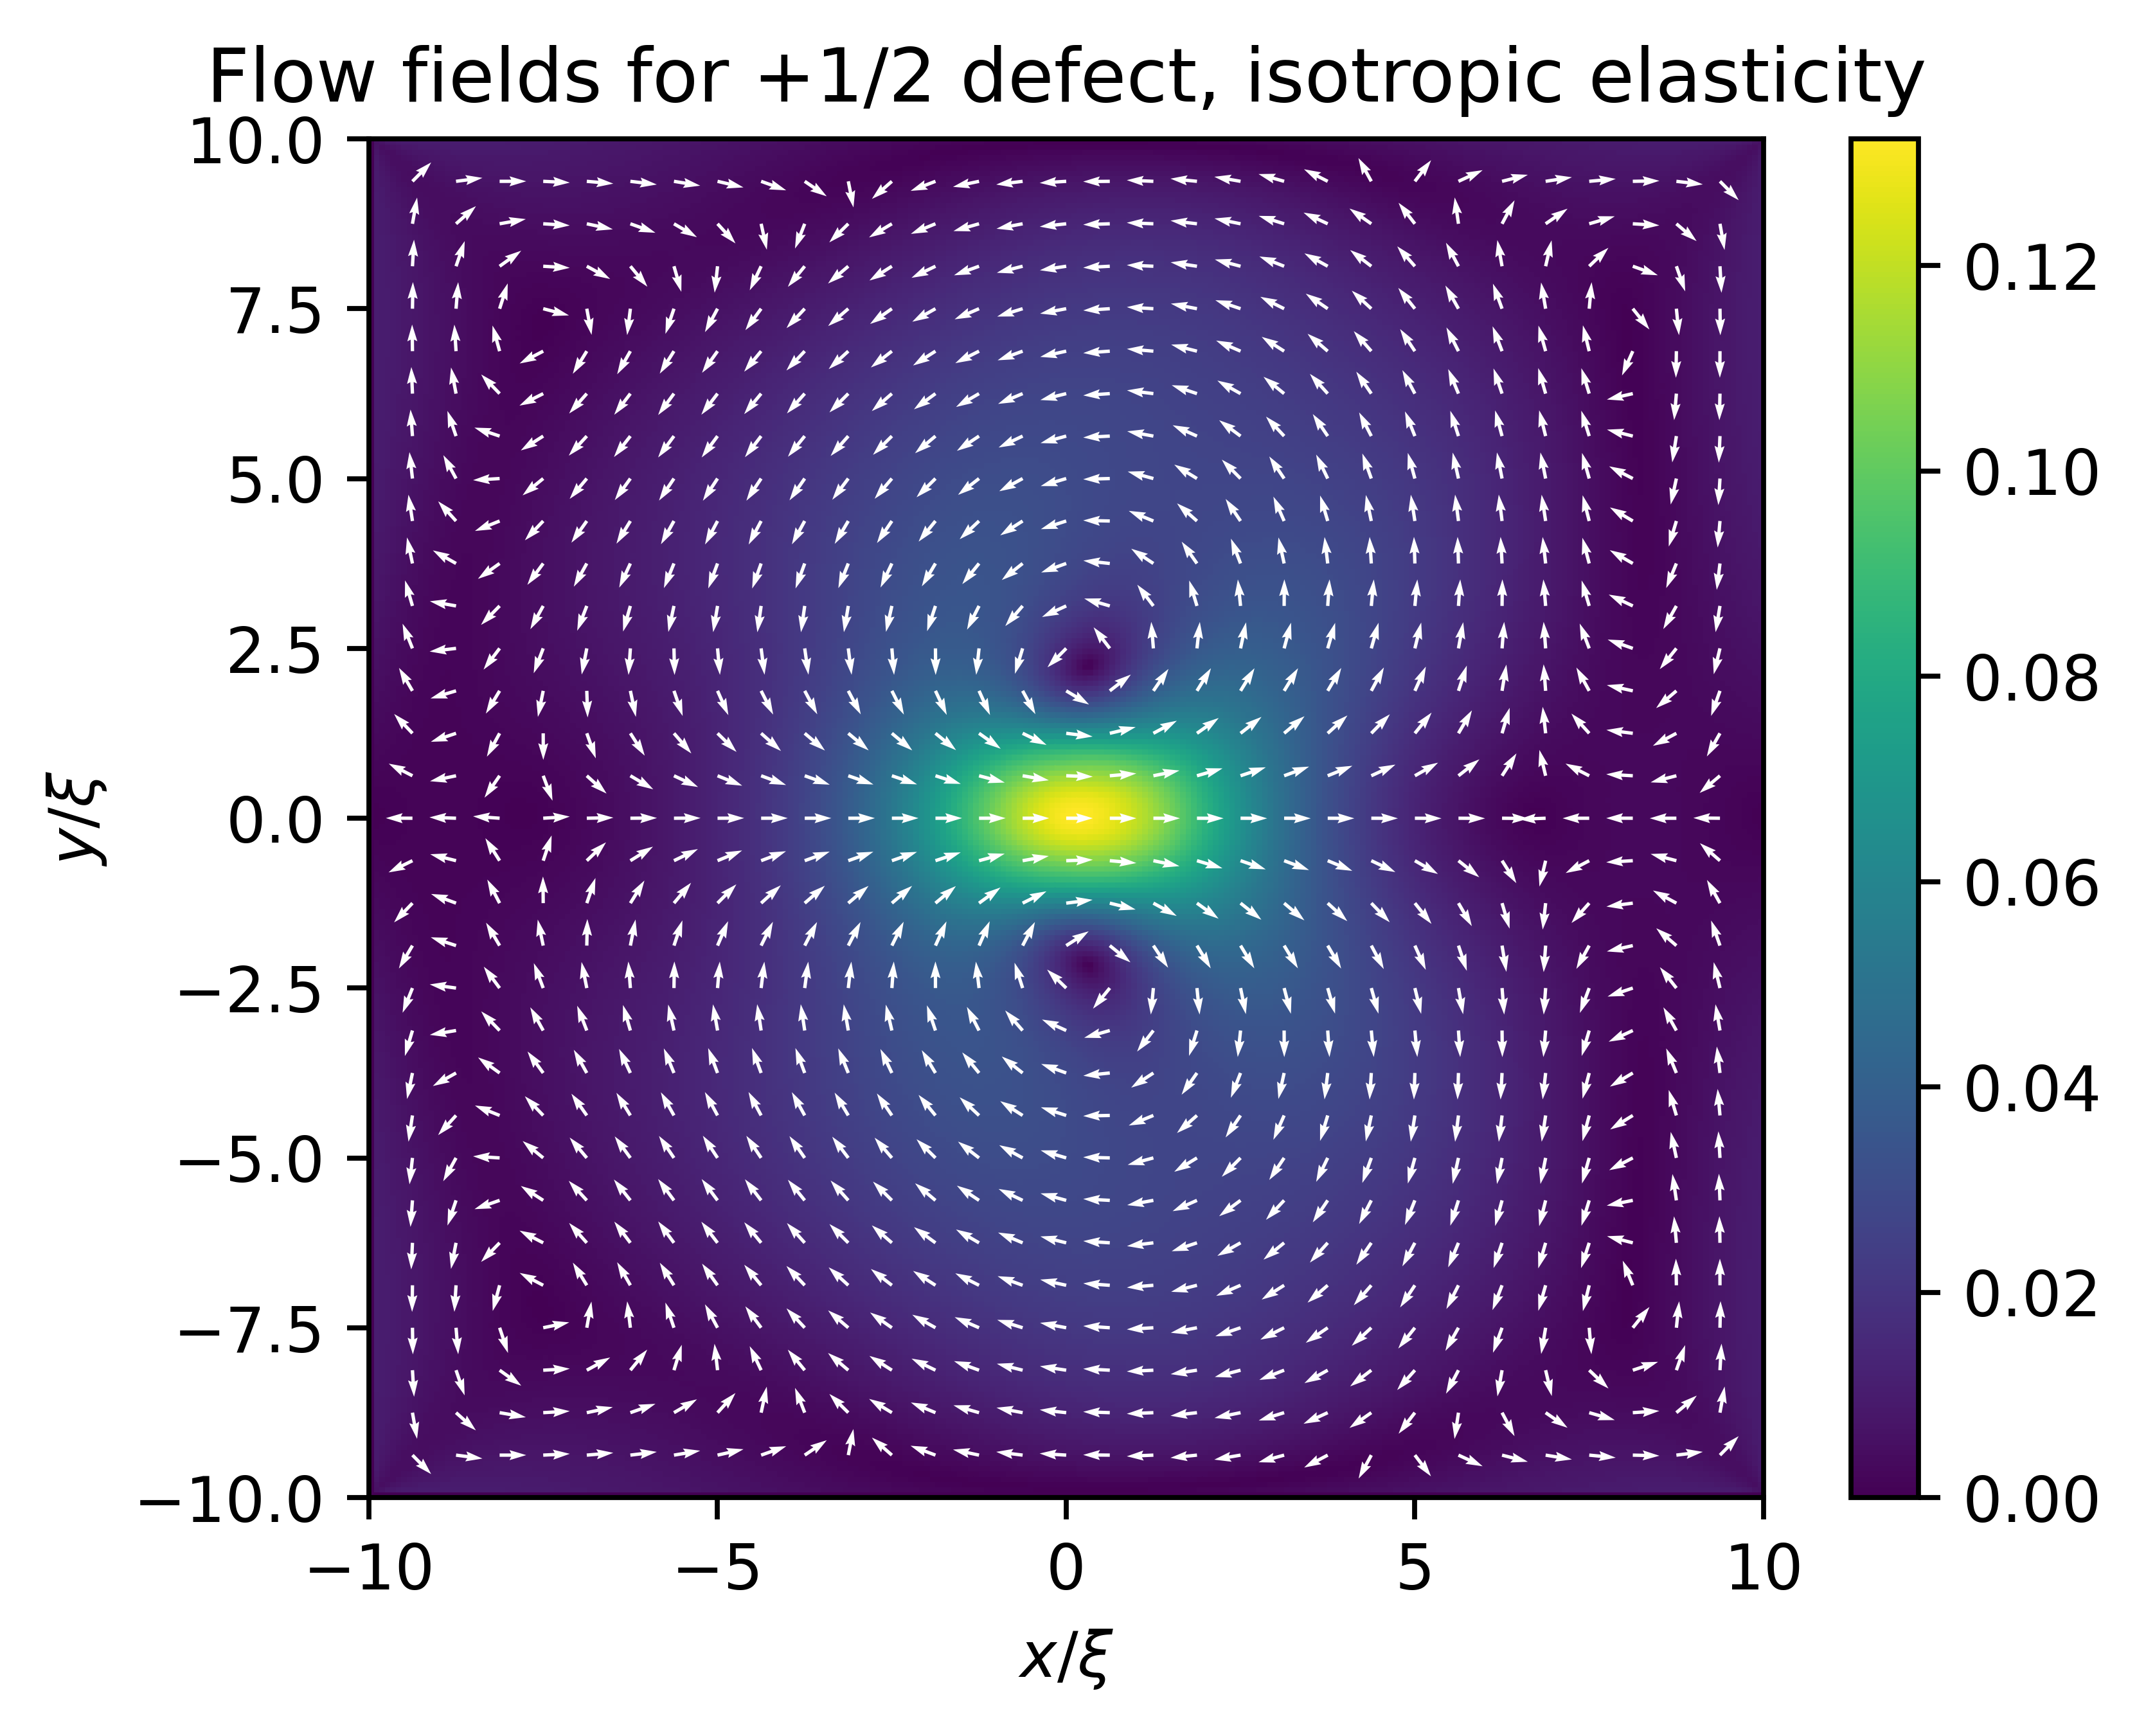

In [11]:
vx, vy = fd.curl(psi, dx)
v = np.sqrt(vx**2 + vy**2)

mask = np.where(v != 0)
vx_norm = np.zeros(vx.shape)
vy_norm = np.zeros(vy.shape)
vx_norm[mask] = vx[mask]/v[mask]
vy_norm[mask] = vy[mask]/v[mask]

sparse_idx = lch.sparseIdx(vx.shape, (30, 30))

fig, ax = plt.subplots(figsize=(5, 4))
c = ax.pcolor(X, Y, v)
fig.colorbar(c, ax=ax)
q = ax.quiver(X[sparse_idx], Y[sparse_idx],
              vx_norm[sparse_idx], vy_norm[sparse_idx], pivot='tail', color='w')
ax.set_title('Flow fields for +1/2 defect, isotropic elasticity')
ax.set_xlabel(r'$x/\xi$')
ax.set_ylabel(r'$y/\xi$')

filename_stress_tensor = os.path.join(save_folder, r'flow-field-1_2-defect-isotropic-elasticity.png')
fig.savefig(filename_stress_tensor)